# Backend Location

In [1]:
import os
import numpy as np
import pandas as pd
import datetime

#implemented
from src.backend.api_wrapper import getData

In [2]:
#helper
def dist2DDeg_KM(x,y):
    """
        Approx distance
    """
    dLon =x["lon"]-y["latitude"]
    dLat =x["lat"]-y["longitude"]
    return dLat*111.32+(40075*np.cos(dLat)/360) *dLon


## input

In [28]:
#Input:
startLocation = "Zürich HB"
starting_time = datetime.datetime.fromisoformat('2021-10-30T12:02:00.036331')

destination = "Ilanz" #None
destination = "Zug"
destination_radius = 50000

suprise:bool = False
    
experience = None
redoAll=True

In [20]:
#Meta Statistics
loss_data = {}

## retrieve Data

In [21]:
oa = getData.outdoor_active()
js = getData.journey_service()
timetable = getData.timetable_info()
weather = getData.weather_forcast()


In [22]:
#Get starting Info
startLocation_OBJ = timetable.get_locationRequest(location=startLocation)[0]
startLocation_ID = startLocation_OBJ["id"]

destination_OBJ = timetable.get_locationRequest(location=destination)[0]
destination_ID = destination_OBJ["id"]
destination_OBJ


{'id': 8502204,
 'name': 'Zug',
 'coordinates': {'latitude': 47.173628, 'longitude': 8.515293},
 'type': 'STATION',
 'tariffBorder': False,
 'weight': 24047,
 'vehicleTypes': ['TRAIN'],
 'links': []}

In [23]:
oa_df = oa.get_dataframe_of_ch(getData.get_coords_request(lat=destination_OBJ["coordinates"]['latitude'], 
                                                          lon=destination_OBJ["coordinates"]['longitude']),
                                                          radius=destination_radius)

In [24]:
oa_df.columns

Index(['lineOptions', 'time', 'length', 'elevation', 'rating', 'labels',
       'startingPoint', 'season', 'startingPointDescr', 'directions',
       'equipment', 'tip', 'destination', 'properties', 'pois',
       'elevationProfile', 'wayType', 'currentConditions', 'difficulties',
       'category', 'title', 'localizedTitle', 'shortText', 'longText',
       'primaryImage', 'geometry', 'images', 'regions', 'winterActivity',
       'meta', 'id', 'type', 'frontendtype', 'ranking', 'publicTransit',
       'gettingThere', 'parking', 'safetyGuidelines', 'additionalInformation',
       'groundDescription', 'crestDescription', 'opened', 'riskPotential',
       'exposition', 'bookWorks', 'avalancheRegions', 'isStageTour',
       'stageTour', 'stageTours', 'isStagesTour', 'joinPointMeter',
       'wallHeight', 'climbingLengthMeter', 'descentMeter',
       'joinPointDuration', 'climbingLengthDuration', 'descentDuration',
       'mapWorks'],
      dtype='object')

In [25]:
oa_df["startingPoint"]

0               {'lon': 8.595566, 'lat': 46.919714}
1               {'lon': 8.571873, 'lat': 47.381701}
2               {'lon': 9.070858, 'lat': 47.040117}
3               {'lon': 8.573265, 'lat': 47.358164}
4               {'lon': 8.816476, 'lat': 47.225099}
                           ...                     
659    {'lon': 8.958437, 'lat': 46.908973999999986}
660    {'lon': 8.900458, 'lat': 46.889777999999986}
661              {'lon': 8.525863, 'lat': 46.99237}
662             {'lon': 8.203416, 'lat': 47.484261}
663     {'lon': 8.645602, 'lat': 46.83650799999999}
Name: startingPoint, Length: 664, dtype: object

In [26]:
oa_df.rating[0]

{'condition': 4,
 'difficulty': 2,
 'technique': 2,
 'qualityOfExperience': 3,
 'landscape': 5}

In [11]:
oa_df.shape

(664, 58)

### Outdoor Activity convenvience Metric

#### Get all close stations to the hikes

In [30]:
oa_df_path = "oa_df_withStations.obj"
if(not os.path.exists(oa_df_path) or redoAll):
    oa_df['closeStations'] = oa_df.apply(lambda x: js.get_locationRequestByCoords(getData.get_coords_request(**x['startingPoint'])), axis=1)
    oa_df.to_pickle(oa_df_path)
else:
    oa_df = pd.read_pickle("oa_df_withStations.obj")    
oa_df.shape

(664, 59)

In [31]:
oa_df['closeStations']

0      [{'type': 'STATION', 'uicOrId': '8573095', 'na...
1      [{'type': 'STATION', 'uicOrId': '8591442', 'na...
2      [{'type': 'STATION', 'uicOrId': '8503230', 'na...
3      [{'type': 'STATION', 'uicOrId': '8591104', 'na...
4      [{'type': 'STATION', 'uicOrId': '8503110', 'na...
                             ...                        
659    [{'type': 'STATION', 'uicOrId': '8505740', 'na...
660    [{'type': 'STATION', 'uicOrId': '8505776', 'na...
661    [{'type': 'STATION', 'uicOrId': '8509538', 'na...
662    [{'type': 'STATION', 'uicOrId': '8580324', 'na...
663    [{'type': 'STATION', 'uicOrId': '8577384', 'na...
Name: closeStations, Length: 664, dtype: object

#### Get closest station to the hikes

In [32]:
#clean empty stations:
f_oa_df = oa_df
drop_empty_stations = [i for i, row in oa_df.iterrows() if(len(row['closeStations'])==0)]

loss_noStation = f_oa_df.iloc[drop_empty_stations]
f_oa_df=f_oa_df.drop(index=drop_empty_stations)
loss_data.update({"noStation":loss_noStation})

f_oa_df.shape

(603, 59)

In [46]:
next_station = []
next_station_d = []
closeStations = []
for i, row in f_oa_df.iterrows():
        if(isinstance(row['closeStations'],list)):
            stations = row['closeStations'] 
            print(type(stations), stations)
            close_stations_distances = [dist2DDeg_KM(row['startingPoint'],station['coordinatesWGS84'])/1000 for station in stations]
            closest_station_i = np.argmin(close_stations_distances)
            closest_station_dmin = np.min(close_stations_distances)
            closest_station = row['closeStations'][closest_station_i]

            #Add info to closeStations
            print(row['closeStations'],)
            [station.update({"distanceToOA": dist}) for station, dist in zip(stations, close_stations_distances)]
            closeStations.append(stations)
            next_station.append(closest_station)
            next_station_d.append(closest_station_dmin)
        else:
            closeStations.append(np.nan)
            next_station.append(np.nan)
            next_station_d.append(np.nan)
        #print("closest_station: ",closest_station_i, closest_station_dmin)
#print(len(close_stations))
f_oa_df["nextStation"] = pd.Series(next_station) 
f_oa_df["closeStations"] = pd.Series(closeStations) 

f_oa_df.dropna(how='all', inplace=True)
f_oa_df.dropna(subset=["closeStations"], inplace=True)

f_oa_df.shape

<class 'list'> [{'type': 'STATION', 'uicOrId': '8573095', 'name': 'Isleten-Isenthal,Schiffstation', 'coordinatesWGS84': {'longitude': 8.59562, 'latitude': 46.919835, 'latitudeDecimalDegrees': 46.919835, 'longitudeDecimalDegrees': 8.59562}, 'cantonCH': 'UR', 'distance': 13, 'categories': [], 'vehicleTypes': ['BUS'], 'weight': 3, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.8064332795757646}, {'type': 'STATION', 'uicOrId': '8508475', 'name': 'Isleten-Isenthal', 'coordinatesWGS84': {'longitude': 8.595755, 'latitude': 46.919925, 'latitudeDecimalDegrees': 46.919925, 'longitudeDecimalDegrees': 8.595755}, 'cantonCH': 'UR', 'distance': 27, 'categories': [], 'vehicleTypes': ['BOAT'], 'weight': 110, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.8060731834675948}, {'type': 'STATION', 'uicOrId': '8505918', 'name': 'Isleten, Seegarten', 'coordinatesWGS84': {'longitude': 8.595351, 'latitude': 46.917516, 'latitudeDecimalDegrees': 46.917516, 'long

[{'type': 'STATION', 'uicOrId': '8508475', 'name': 'Isleten-Isenthal', 'coordinatesWGS84': {'longitude': 8.595755, 'latitude': 46.919925, 'latitudeDecimalDegrees': 46.919925, 'longitudeDecimalDegrees': 8.595755}, 'cantonCH': 'UR', 'distance': 17, 'categories': [], 'vehicleTypes': ['BOAT'], 'weight': 110, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.8062690054469467}, {'type': 'STATION', 'uicOrId': '8573095', 'name': 'Isleten-Isenthal,Schiffstation', 'coordinatesWGS84': {'longitude': 8.59562, 'latitude': 46.919835, 'latitudeDecimalDegrees': 46.919835, 'longitudeDecimalDegrees': 8.59562}, 'cantonCH': 'UR', 'distance': 18, 'categories': [], 'vehicleTypes': ['BUS'], 'weight': 3, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.806629128967249}, {'type': 'STATION', 'uicOrId': '8505918', 'name': 'Isleten, Seegarten', 'coordinatesWGS84': {'longitude': 8.595351, 'latitude': 46.917516, 'latitudeDecimalDegrees': 46.917516, 'longitudeDecimalDegr

<class 'list'> [{'type': 'STATION', 'uicOrId': '8505667', 'name': 'Amsteg, Post', 'coordinatesWGS84': {'longitude': 8.670977, 'latitude': 46.769733, 'latitudeDecimalDegrees': 46.769733, 'longitudeDecimalDegrees': 8.670977}, 'cantonCH': 'UR', 'distance': 11, 'categories': [], 'vehicleTypes': ['BUS'], 'weight': 471, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.33409436184048175}, {'type': 'STATION', 'uicOrId': '8588654', 'name': 'Amsteg, Schulhaus', 'coordinatesWGS84': {'longitude': 8.670033, 'latitude': 46.772187, 'latitudeDecimalDegrees': 46.772187, 'longitudeDecimalDegrees': 8.670033}, 'cantonCH': 'UR', 'distance': 292, 'categories': [], 'vehicleTypes': ['BUS'], 'weight': 471, 'destinationTrends': None, 'tariffBorderPoint': False, 'distanceToOA': 0.33550710849804455}, {'type': 'STATION', 'uicOrId': '8573086', 'name': 'Amsteg, St. Anton', 'coordinatesWGS84': {'longitude': 8.678744, 'latitude': 46.769509, 'latitudeDecimalDegrees': 46.769509, 'longitudeDecimal

(502, 60)

In [47]:
closest_station

{'type': 'STATION',
 'uicOrId': '8587505',
 'name': 'Erstfeld, Birtschen',
 'coordinatesWGS84': {'longitude': 8.647326,
  'latitude': 46.828208,
  'latitudeDecimalDegrees': 46.828208,
  'longitudeDecimalDegrees': 8.647326},
 'cantonCH': 'UR',
 'distance': 932,
 'categories': [],
 'vehicleTypes': ['BUS'],
 'weight': 471,
 'destinationTrends': None,
 'tariffBorderPoint': False,
 'distanceToOA': 0.5924401017980854}

In [48]:
f_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,joinPointMeter,wallHeight,climbingLengthMeter,descentMeter,joinPointDuration,climbingLengthDuration,descentDuration,mapWorks,closeStations,nextStation
0,{'strokeColor': '#8b5831'},{'min': 210},28499.000000,"{'ascent': 1284, 'descent': 1284, 'minAltitude...","{'condition': 4, 'difficulty': 2, 'technique':...",{'top': True},"{'lon': 8.595566, 'lat': 46.919714}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Isleten, Schiffshafen",Isleten - Isenthal - Biwaldalp - Isenthal - Sc...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8573095', 'na...","{'type': 'STATION', 'uicOrId': '8508475', 'nam..."
1,{'strokeColor': '#8b5831'},{'min': 150},21122.000000,"{'ascent': 444, 'descent': 444, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.571873, 'lat': 47.381701}","{'jan': False, 'feb': False, 'mar': True, 'apr...",Zoo Zürich,Zoo Zürich - Lorenchopf - Forch - Zollikerberg...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8591442', 'na...","{'type': 'STATION', 'uicOrId': '8591443', 'nam..."
2,{'strokeColor': '#8b5831'},{'min': 150},15252.596960,"{'ascent': 628, 'descent': 628, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'qualityOfEx...","{'top': True, 'publicTransportFriendly': True}","{'lon': 9.070858, 'lat': 47.040117}","{'jan': False, 'feb': False, 'mar': True, 'apr...","Glarus, Bahnhof",Glarus-Schwammhöhe-Glarus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8503230', 'na...","{'type': 'STATION', 'uicOrId': '8580486', 'nam..."
3,{'strokeColor': '#8b5831'},{'min': 138},19130.579100,"{'ascent': 482, 'descent': 518, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.573265, 'lat': 47.358164}","{'jan': False, 'feb': False, 'mar': True, 'apr...","Zürich Burgwies, Tram Station","<p>Zürich Burgwies, Tram Station - Trichtenhau...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8591104', 'na...","{'type': 'STATION', 'uicOrId': '8591424', 'nam..."
4,{'strokeColor': '#db38c9'},{'min': 559},147652.975712,"{'ascent': 2489, 'descent': 2517, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...","{'top': True, 'publicTransportFriendly': True}","{'lon': 8.816476, 'lat': 47.225099}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Bahnhof Rapperswil,Von Rapperswil geht es über den Seedamm und da...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8503110', 'na...","{'type': 'STATION', 'uicOrId': '8591754', 'nam..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,{'strokeColor': '#8b5831'},{'min': 300},48802.542630,"{'ascent': 1539, 'descent': 1539, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.74507, 'lat': 47.12846999999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Einsiedeln, Bahnhof",Einsiedeln - Chälen - Ober Tries - Hummel - Eu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8508692', 'na...","{'type': 'STATION', 'uicOrId': '8508692', 'nam..."
542,{'strokeColor': '#8b5831'},{'min': 105},9153.384346,"{'ascent': 150, 'descent': 919, 'minAltitude':...","{'condition': 4, 'difficulty': 3, 'technique':...",NaN,"{'lon': 8.65108, 'lat': 46.82001999999998}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Erstfeld, Bahnhof",Erstfeld - Schwandibahn - Ob Schwandi - Sträng...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8505740', 'na...","{'type': 'STATION', 'uicOrId': '8505740', 'nam..."
543,{'strokeColor': '#8b5831'},{'min': 180},32132.922647,"{'ascent': 680, 'descent': 680, 'minAltitude':...","{'condition': 4, 'difficulty': 2, 'technique':...",NaN,"{'lon': 8.5151, 'lat': 47.17322}","{'jan': False, 'feb': F

#### get travel route

In [51]:
#Travel Time and changes
def get_fastest_trip(destinationStation_ID, startLocation_ID, starting_time):
    trip_request = getData.generate_trip_dict(originId=startLocation_ID,
                                              destinationId=destinationStation_ID,
                                              date=starting_time.date(),
                                              time=starting_time.time())
    print(trip_request)
    trips = timetable.get_tripRequest(trip_request)
    if(len(trips) == 0):
        return np.nan
    else:
        t_deltas = []
        segments = []
        for trip in trips:
            start_time = datetime.datetime.fromisoformat(trip['segments'][0]['stops'][0]['departureDateTime'])
            end_time = datetime.datetime.fromisoformat(trip['segments'][-1]['stops'][-1]["arrivalDateTime"])
            deltaT = end_time-start_time
            segments.append(len(trip['segments']))
            t_deltas.append(deltaT.seconds)

        t_deltas = np.array(t_deltas)
        segments = np.array(segments)
        
        fastest_trip_i = np.argmin(t_deltas)
        fastest_trip = trips[np.argmin(t_deltas)]
        fastest_trip_t = np.min(t_deltas)
        fastest_trip.update({"t":fastest_trip_t, "nSegments": segments[fastest_trip_i]})
        return fastest_trip
    
trip_oa_df_path = "oa_df_withStations_withTrips.obj"
if(not os.path.exists(trip_oa_df_path) or redoAll):
    trip_oa_df = f_oa_df
    trip_oa_df["fastestTripToDestination"] = trip_oa_df.apply(lambda x: get_fastest_trip(x["nextStation"]['uicOrId'], startLocation_ID=startLocation_ID, starting_time=starting_time), axis=1)
    trip_oa_df["fastestTripHome"] = trip_oa_df.apply(lambda x: get_fastest_trip(startLocation_ID=startLocation_ID, destinationStation_ID=x["nextStation"]['uicOrId'], starting_time=starting_time+datetime.timedelta(minutes=x["time"]["min"])), axis=1)
    trip_oa_df.dropna(subset=["fastestTripToDestination", "fastestTripHome"], inplace=True)
    trip_oa_df.to_pickle(trip_oa_df_path)
else:
    trip_oa_df = pd.read_pickle(trip_oa_df_path)
trip_oa_df.dropna(subset=["fastestTripToDestination", "fastestTripHome"], inplace=True)

trip_oa_df.shape

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8508475')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8591443')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8580486')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8591424')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8591754')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573055')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573055')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8508728')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8508

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8595490')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8587979')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502915')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8508456')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573856')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530418')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8578594')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530781')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8503

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8587945')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8578500')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8578609')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8590302')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8588198')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8590174')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8591759')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573894')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8503

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8577435')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502294')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8587950')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8581161')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502008')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8577302')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8595500')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8503240')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8578

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8595189')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8580252')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573789')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573982')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8507322')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8572948')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502022')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530426')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8503

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8581466')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502005')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573246')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8573104')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8580197')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530375')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8510050')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8581584')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8581

OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8502250')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8508877')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8587691')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8580197')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530406')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530375')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8505975')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530406')])
OrderedDict([('date', '2021-10-30'), ('time', '12:02'), ('originId', '8503000'), ('destinationId', '8530

OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8508368')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8502867')])
OrderedDict([('date', '2021-10-30'), ('time', '17:32'), ('originId', '8503000'), ('destinationId', '8502867')])
OrderedDict([('date', '2021-10-30'), ('time', '15:02'), ('originId', '8503000'), ('destinationId', '8577544')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8502292')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8505975')])
OrderedDict([('date', '2021-10-30'), ('time', '18:17'), ('originId', '8503000'), ('destinationId', '8508368')])
OrderedDict([('date', '2021-10-30'), ('time', '15:47'), ('originId', '8503000'), ('destinationId', '8508496')])
OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8502

OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8503623')])
OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8587691')])
OrderedDict([('date', '2021-10-30'), ('time', '16:32'), ('originId', '8503000'), ('destinationId', '8590302')])
OrderedDict([('date', '2021-10-30'), ('time', '17:47'), ('originId', '8503000'), ('destinationId', '8502292')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8505975')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8510050')])
OrderedDict([('date', '2021-10-30'), ('time', '16:32'), ('originId', '8503000'), ('destinationId', '8589197')])
OrderedDict([('date', '2021-10-30'), ('time', '21:02'), ('originId', '8503000'), ('destinationId', '8508735')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8578

OrderedDict([('date', '2021-10-30'), ('time', '17:02'), ('originId', '8503000'), ('destinationId', '8591754')])
OrderedDict([('date', '2021-10-30'), ('time', '14:32'), ('originId', '8503000'), ('destinationId', '8503117')])
OrderedDict([('date', '2021-10-30'), ('time', '19:32'), ('originId', '8503000'), ('destinationId', '8573777')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8508735')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8502294')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8508877')])
OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8500576')])
OrderedDict([('date', '2021-10-30'), ('time', '14:32'), ('originId', '8503000'), ('destinationId', '8503390')])
OrderedDict([('date', '2021-10-31'), ('time', '21:56'), ('originId', '8503000'), ('destinationId', '8502

OrderedDict([('date', '2021-10-30'), ('time', '17:17'), ('originId', '8503000'), ('destinationId', '8583653')])
OrderedDict([('date', '2021-10-30'), ('time', '18:47'), ('originId', '8503000'), ('destinationId', '8508877')])
OrderedDict([('date', '2021-10-30'), ('time', '15:47'), ('originId', '8503000'), ('destinationId', '8530477')])
OrderedDict([('date', '2021-10-30'), ('time', '15:02'), ('originId', '8503000'), ('destinationId', '8508660')])
OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8578609')])
OrderedDict([('date', '2021-10-30'), ('time', '15:17'), ('originId', '8503000'), ('destinationId', '8580724')])
OrderedDict([('date', '2021-10-30'), ('time', '12:47'), ('originId', '8503000'), ('destinationId', '8591217')])
OrderedDict([('date', '2021-10-30'), ('time', '13:02'), ('originId', '8503000'), ('destinationId', '8502250')])
OrderedDict([('date', '2021-10-30'), ('time', '16:17'), ('originId', '8503000'), ('destinationId', '8502

OrderedDict([('date', '2021-10-30'), ('time', '17:32'), ('originId', '8503000'), ('destinationId', '8589197')])
OrderedDict([('date', '2021-10-30'), ('time', '15:47'), ('originId', '8503000'), ('destinationId', '8591752')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8573125')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8590656')])
OrderedDict([('date', '2021-10-30'), ('time', '13:02'), ('originId', '8503000'), ('destinationId', '8500576')])
OrderedDict([('date', '2021-10-30'), ('time', '13:17'), ('originId', '8503000'), ('destinationId', '8590142')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8577543')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8590174')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8503

OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8595490')])
OrderedDict([('date', '2021-10-30'), ('time', '16:02'), ('originId', '8503000'), ('destinationId', '8508497')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8505067')])
OrderedDict([('date', '2021-10-30'), ('time', '18:32'), ('originId', '8503000'), ('destinationId', '8593445')])
OrderedDict([('date', '2021-10-30'), ('time', '15:02'), ('originId', '8503000'), ('destinationId', '8577563')])
OrderedDict([('date', '2021-10-30'), ('time', '19:02'), ('originId', '8503000'), ('destinationId', '8593460')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8573789')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8508316')])
OrderedDict([('date', '2021-10-30'), ('time', '13:32'), ('originId', '8503000'), ('destinationId', '8573

OrderedDict([('date', '2021-10-30'), ('time', '12:47'), ('originId', '8503000'), ('destinationId', '8508316')])
OrderedDict([('date', '2021-10-30'), ('time', '12:47'), ('originId', '8503000'), ('destinationId', '8572893')])
OrderedDict([('date', '2021-10-30'), ('time', '14:02'), ('originId', '8503000'), ('destinationId', '8581466')])
OrderedDict([('date', '2021-10-30'), ('time', '16:47'), ('originId', '8503000'), ('destinationId', '8502250')])
OrderedDict([('date', '2021-10-30'), ('time', '15:32'), ('originId', '8503000'), ('destinationId', '8508983')])
OrderedDict([('date', '2021-10-30'), ('time', '16:47'), ('originId', '8503000'), ('destinationId', '8508707')])
OrderedDict([('date', '2021-10-30'), ('time', '15:47'), ('originId', '8503000'), ('destinationId', '8502536')])
OrderedDict([('date', '2021-10-30'), ('time', '17:17'), ('originId', '8503000'), ('destinationId', '8530420')])
OrderedDict([('date', '2021-10-30'), ('time', '15:17'), ('originId', '8503000'), ('destinationId', '8587

(467, 62)

In [ ]:
trip_oa_df['nextStation']

### Extract Features

In [ ]:
fastest_trip_time = pd.Series([float(x["fastestTripToDestination"]['t'])/60 for x in trip_oa_df["fastestTripToDestination"]])
nsegments_trip = pd.Series([float(x["fastestTripToDestination"]['nSegments']) for x in trip_oa_df["fastestTripToDestination"]])
last_mileDist = pd.Series([float(x['distanceToOA']) for x in trip_oa_df["nextStation"]])

trip_oa_df["feat_tripTime"] = fastest_trip_time
trip_oa_df["feat_nsegments_trip"] = nsegments_trip
trip_oa_df["feat_lastMile"] = last_mileDist


In [ ]:
trip_oa_df.columns

#### judge travel convenience

In [103]:
sortedtrip_oa_df = trip_oa_df.sort_values(by=['feat_tripTime', "feat_lastMile", "feat_nsegments_trip"])
sortedtrip_oa_df

,lineOptions,time,length,elevation,rating,labels,startingPoint,season,startingPointDescr,directions,...,currentConditions,opened,closeStations,nextStation,nextStation_d,fastestTripToDestination,fastestTripHome,feat_tripTime,feat_nsegments_trip,feat_lastMile
0,{'strokeColor': '#8b5831'},{'min': 435},73447.000000,"{'ascent': 1804, 'descent': 1804, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.20795, 'lat': 46.77519}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Ilanz, Bahnhof",Ilanz - Valendas - Versam - Safien Platz - Saf...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8575120', 'na...","{'type': 'STATION', 'uicOrId': '8575019', 'nam...",0.030952,lineOptions ...,{'tripId': 'iQ7wSQoCVjEShwbCtkhLScK2VCRBPTFATz...,108.0,3.0,0.030952
1,{'strokeColor': '#2e5676'},{'min': 180},9984.000000,"{'ascent': 1048, 'descent': 1048, 'minAltitude...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.163202, 'lat': 46.791019}","{'jan': True, 'feb': True, 'mar': True, 'apr':...","Siat, Bushaltestelle",Dalpaleus - Runvagau,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509879', 'na...","{'type': 'STATION', 'uicOrId': '8575097', 'nam...",0.010281,lineOptions ...,{'tripId': 'jxDwSQoCVjESgQbCtkhLScK2VCRBPTFATz...,112.0,3.0,0.010281
2,{'strokeColor': '#9e324a'},{'min': 120},7682.000000,"{'ascent': 36, 'descent': 36, 'minAltitude': 1...","{'condition': 2, 'difficulty': 1, 'technique':...",{'top': True},"{'lon': 9.281379, 'lat': 46.83425499999999}","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Sessellift Foppa",Flims - Foppa - Uaul Steina - Muletg - Runca S...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509164', 'na...","{'type': 'STATION', 'uicOrId': '8582908', 'nam...",0.042262,lineOptions ...,{'tripId': 'iQ_wSQoCVjESyAfCtkhLScK2VCRBPTFATz...,112.0,3.0,0.042262
3,{'strokeColor': '#8b5831'},{'min': 255},29476.000000,"{'ascent': 1492, 'descent': 1492, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",{'top': True},"{'lon': 9.286929999999998, 'lat': 46.836609999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Post",Flims - Crestasee - Trin Mulin - Trin - Alp Mo...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509773', 'na...","{'type': 'STATION', 'uicOrId': '8582907', 'nam...",0.042927,lineOptions ...,{'tripId': '0_xDwSQoCVjESxQfCtkhLScK2VCRBPTFAT...,118.0,4.0,0.042927
5,{'strokeColor': '#8b5831'},{'min': 330},33789.705872,"{'ascent': 1614, 'descent': 1614, 'minAltitude...","{'condition': 5, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.265120000000001, 'lat': 46.819779999...","{'jan': False, 'feb': False, 'mar': False, 'ap...","Flims, Talstation Gondelbahn Crap Sogn Gion",Murschetg - Falera - Station Crap Sogn Gion - ...,...,{'currentCondition': [{'id': '64024538'}]},False,"[{'type': 'STATION', 'uicOrId': '8574991', 'na...","{'type': 'STATION', 'uicOrId': '8557046', 'nam...",0.030110,lineOptions ...,{'tripId': 'jA7wSQoCVjEShgbCtkhLScK2VCRBPTFATz...,121.0,4.0,0.043105
6,{'strokeColor': '#4134b3'},{'min': 150},6186.598111,"{'ascent': 380, 'descent': 380, 'minAltitude':...","{'condition': 3, 'difficulty': 2, 'technique':...",NaN,"{'lon': 9.19976234436035, 'lat': 46.7711441794...","{'jan': True, 'feb': True, 'mar': False, 'apr'...",Flond,Wir gehen die Alte Flonderstrasse ca. bis wir ...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509786', 'na...","{'type': 'STATION', 'uicOrId': '8575015', 'nam...",0.043105,lineOptions ...,{'tripId': 'gRHwSQoCVjES7gTCtkhLScK2VCRBPTFATz...,129.0,4.0,0.012864
7,{'strokeColor': '#8b5831'},{'min': 315},34638.351650,"{'ascent': 1919, 'descent': 1919, 'minAltitude...","{'condition': 6, 'difficulty': 3, 'technique':...",NaN,"{'lon': 9.257, 'lat': 46.80641}","{'jan': False, 'feb': False, 'mar': False, 'ap...",Parkplatz beim See in Laax,Parkplatz Laax - Mulin - Talsation Laax - Alp ...,...,NaN,NaN,"[{'type': 'STATION', 'uicOrId': '8509306', 'na...","{'type': 'STATION', 'uicOrId': '8

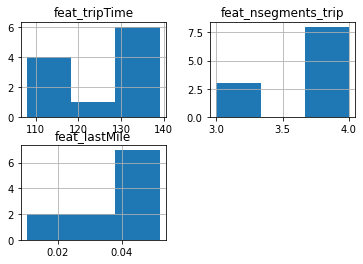

In [115]:
data = trip_oa_df.hist(column=[x for x in trip_oa_df.columns if("feat" in x)], bins=int(np.ceil(trip_oa_df.shape[0]*0.2)))

In [123]:
vars(data[0][0])

{'_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <AxesSubplot:title={'center':'feat_tripTime'}>,
 'figure': <Figure size 432x288 with 4 Axes>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x25c51400448>,
 '_remove_method': <bound method FigureBase.delaxes of <Figure size 432x288 with 4 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_position': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_originalPosition': Bbox([[0.125, 0.5517391304347825], [0.4619565217391305, 0.88]]),
 '_aspect': 'auto',
 '_adjustable': 'box',
 '

In [141]:
trip_oa_df[[x for x in trip_oa_df.columns if("feat" in x)]].dropna()

,feat_tripTime,feat_nsegments_trip,feat_lastMile
0,108.0,3.0,0.030952
1,112.0,3.0,0.010281
2,112.0,3.0,0.042262
3,118.0,4.0,0.042927
5,121.0,4.0,0.043105
6,129.0,4.0,0.012864
7,130.0,4.0,0.050806
8,131.0,4.0,0.051961
9,133.0,4.0,0.030932
10,134.0,4.0,0.050784


In [148]:
pd.np.histogram2d(x=trip_oa_df["feat_tripTime"].dropna(), y=trip_oa_df["feat_lastMile"].dropna())
from matplotlib import pyplot as plt

C:\Users\benja\anaconda3\envs\polyHack2021_SBB\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


(array([[1., 1., 0., 1.],
        [0., 0., 0., 2.],
        [1., 0., 0., 2.],
        [0., 1., 0., 2.]]),
 array([108.  , 115.75, 123.5 , 131.25, 139.  ]),
 array([0.01028066, 0.02070069, 0.03112071, 0.04154074, 0.05196076]),
 <matplotlib.collections.QuadMesh at 0x25c51e1f288>)

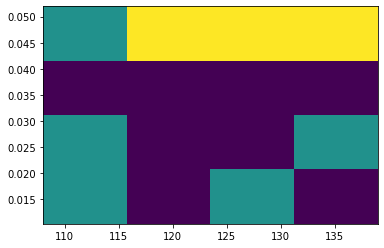

In [151]:
plt.hist2d(x=trip_oa_df["feat_tripTime"].dropna(), y=trip_oa_df["feat_lastMile"].dropna(), bins=4)

### Outdoor Activity Weather metric

In [99]:
destination = trip_oa_df.iloc[0]
weather_request = getData.get_weather_request()#time=starting_time, location=[destination["startingPoint"]["lon"], destination["startingPoint"]["lat"]])
weather.get_weather(weather_request)


token was still valid
2021-10-29T00:00:00+02:00/t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,precip_1h:mm/47.4245,9.3767/csv

<Response [403]>
Access not allowed: forbidden


IndexError: list index out of range

## Punkte:
* more broad decision for different stations and travelling times
    * decide by distance, segment number, tarveling time
* 

In [ ]:
starting_time.time().strftime('%H:%M')